In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve,auc

In [ ]:
con = sqlite3.connect('/content/drive/My Drive/Machine learning/Amazon_review/database.sqlite')
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 105814""", con) 
# LIMIT 105814
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
def partition(x):
  if x < 3:
    return 0
  return 1
a = data['Score']
b = a.map(partition)
data['Score'] = b
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
data['Score'].shape

(105814,)

In [ ]:
sorted_data = data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=True)
sorted_data=sorted_data[sorted_data.HelpfulnessNumerator<=sorted_data.HelpfulnessDenominator]
final = sorted_data
final.shape

(92336, 10)

In [ ]:
import re
 
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
 
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 92336/92336 [00:33<00:00, 2771.17it/s]


In [ ]:
b = sorted_data['Score'].values
preprocessed_reviews = np.array(preprocessed_reviews)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(preprocessed_reviews,b,test_size = 0.2)

In [ ]:
vectorizer = CountVectorizer(min_df=10,binary=True,lowercase=False,ngram_range=(1,4))
vectorizer.fit(X_train)
X_train_bow = vectorizer.transform(X_train)
X_test_bow = vectorizer.transform(X_test)
print(X_train_bow)
print(X_test_bow)

  (0, 1648)	1
  (0, 1660)	1
  (0, 2348)	1
  (0, 2373)	1
  (0, 4433)	1
  (0, 6033)	1
  (0, 6036)	1
  (0, 7608)	1
  (0, 7747)	1
  (0, 8336)	1
  (0, 9472)	1
  (0, 9493)	1
  (0, 9628)	1
  (0, 9672)	1
  (0, 13043)	1
  (0, 13703)	1
  (0, 16834)	1
  (0, 19684)	1
  (0, 22490)	1
  (0, 25359)	1
  (0, 27190)	1
  (0, 32331)	1
  (0, 38332)	1
  (0, 44457)	1
  (0, 44458)	1
  :	:
  (73866, 31479)	1
  (73866, 34272)	1
  (73866, 34275)	1
  (73866, 35328)	1
  (73866, 35330)	1
  (73866, 35869)	1
  (73866, 37305)	1
  (73866, 38630)	1
  (73866, 40293)	1
  (73866, 40305)	1
  (73866, 48762)	1
  (73866, 49022)	1
  (73867, 7)	1
  (73867, 23)	1
  (73867, 7608)	1
  (73867, 11806)	1
  (73867, 17092)	1
  (73867, 19422)	1
  (73867, 19423)	1
  (73867, 19785)	1
  (73867, 19786)	1
  (73867, 19980)	1
  (73867, 24744)	1
  (73867, 24799)	1
  (73867, 25586)	1
  (0, 277)	1
  (0, 330)	1
  (0, 897)	1
  (0, 984)	1
  (0, 4433)	1
  (0, 4535)	1
  (0, 5376)	1
  (0, 11806)	1
  (0, 17383)	1
  (0, 18875)	1
  (0, 20275)	1
  (0, 20277)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
print(X_train_bow.shape)
print(X_test_bow.shape)

(73868, 49494)
(18468, 49494)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB(class_prior=[0.5,0.5])

In [ ]:
params = [{'alpha' : [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}]
# nb = BernoulliNB(class_prior=[0.5,0.5])
clf = GridSearchCV(nb,param_grid=params,scoring='roc_auc',cv=10,verbose=1,return_train_score=True,n_jobs=-1)
clf.fit(X_train_bow,Y_train)
train_auc = clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']
best_alpha=clf.best_params_['alpha']
bestScore=clf.best_score_

print(best_alpha)
print(bestScore)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.4s


0.1
0.9482477727077855


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   22.1s finished


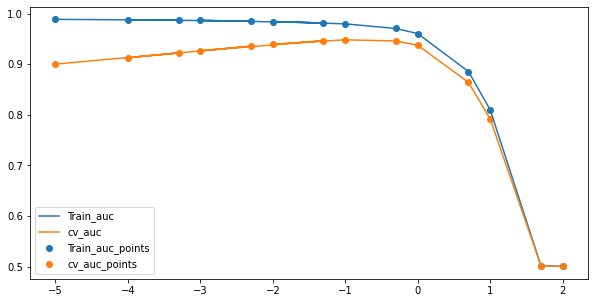

In [ ]:
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha =[]
for a in (alpha):
    b = np.log10(a)
    log_alpha.append(b)
plt.figure(figsize=(10,5))
plt.plot(log_alpha,train_auc,label='Train_auc')
plt.plot(log_alpha,cv_auc,label='cv_auc')
plt.scatter(log_alpha,train_auc,label='Train_auc_points')
plt.scatter(log_alpha,cv_auc,label='cv_auc_points')
plt.legend()

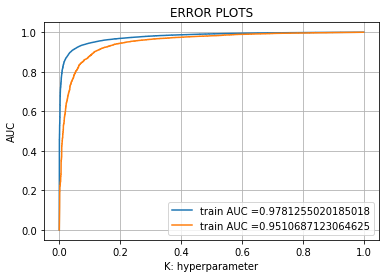

In [ ]:
nb = BernoulliNB(alpha=best_alpha,class_prior=[0.5,0.5])
nb.fit(X_train_bow,Y_train)
Y_train_proba = nb.predict_proba(X_train_bow)[:,1]
Y_test_proba = nb.predict_proba(X_test_bow)[:,1]

train_fpr,train_tpr,tr_treshold = roc_curve(Y_train,Y_train_proba)
test_fpr,test_tpr,te_treshold = roc_curve(Y_test,Y_test_proba)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [ ]:
def predict(s):
  preprocessed_reviews = []
  sentanc = s
  sentanc = re.sub(r"http\S+", "", sentanc)
  sentanc = BeautifulSoup(sentanc, 'lxml').get_text()
  sentanc = decontracted(sentanc)
  sentanc = re.sub("\S*\d\S*", "", sentanc).strip()
  sentanc = re.sub('[^A-Za-z]+', ' ', sentanc)
  sentanc = ' '.join(e.lower() for e in sentanc.split() if e.lower() not in stopwords)
  preprocessed_reviews.append(sentanc.strip())
  preprocessed_reviews = np.array(preprocessed_reviews)
  vectoried_review = vectorizer.transform(preprocessed_reviews)
  x = nb.predict(vectoried_review)
  for d in x:
    if d==1:
      print('Positive Review')
    else:
      print("Negative Review")

In [ ]:
predict('After reading all of the other reviews, I was expecting some thing a little bit more like a tennis shoe. The heels on these were so high and full of air that I felt like I was walking on platform shoes. I felt like I was going to roll my ankle in them and because it’s a slip on shoe I couldn’t tie them any tighter. They felt comfortable just standing but as soon as I started to move I just felt like they were going to slip off. Not what I want in a walking shoe. I felt like I would be more likely to roll my ankle in them than anything else. Getting sent back!')

Negative Review
